In [1]:
import os
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from Prototype.crystal_structure import CrystalStructure


In [2]:
class LatticeGenerator:
    def __init__(self, base_directory, species_count, dimension):
        self.base_directory = base_directory
        self.species_count = species_count
        self.dimension = dimension

    def generate_lattice(self, nx, ny):
        raise NotImplementedError("Subclasses should implement this method")

    def generate_filename(self, nx, ny, vertices_count):
        raise NotImplementedError("Subclasses should implement this method")

    def save_structure(self, nx, ny):
        positions, interactions = self.generate_lattice(nx, ny)
        vertices_count = len(positions)
        crystal = CrystalStructure(vertices_count, self.species_count, self.dimension)

        for position in positions:
            crystal.add_position(*position)

        for interaction_pair, interaction_value in interactions.items():
            crystal.add_interaction(*interaction_pair, interaction_value)

        filename = self.generate_filename(nx, ny, vertices_count)
        filepath = os.path.join(self.base_directory, filename)
        crystal.to_file(filepath)
        print(f"Saved: {filepath}")


class GrapheneLatticeGenerator(LatticeGenerator):
    def generate_lattice(self, nx, ny):
        positions = self.generate_positions(nx, ny)
        interactions = self.find_bonded_interactions(positions, bond_length=1.01, interaction_energy=[0, 0, 0, -0.1])
        return positions, interactions

    def generate_positions(self, nx, ny):
        PRECISION = 5
        b1 = np.array([1, 0])
        b2 = np.array([0.5, sqrt(3)/2])
        positions = set()

        for i in range(nx):
            for j in range(ny):
                pos = (i * b1 + j * b2) * sqrt(3)
                for k in range(6):
                    angle = 2 * np.pi * k / 6
                    offset = np.array([np.sin(angle), np.cos(angle)])
                    vertex = tuple(np.around(pos + offset, decimals=PRECISION))
                    positions.add(vertex)
        return list(positions)

    def find_bonded_interactions(self, positions, bond_length, interaction_energy):
        new_interactions = {}
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                if self.calculate_distance(positions[i], positions[j]) <= bond_length:
                    new_interactions[(i, j)] = interaction_energy
        return new_interactions

    @staticmethod
    def calculate_distance(pos1, pos2):
        return sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(pos1, pos2)))

    def generate_filename(self, nx, ny, vertices_count):
        return f'graphene_supercell_nx_{nx}_ny_{ny}.dat'

In [3]:
nx_list = [1, 2, 3, 4, 5]
ny_list = [1, 1, 1, 1, 1]
base_directory = '../native_crystal_database/benchmark_crystals'

os.makedirs(base_directory, exist_ok=True)

# Instantiate a generator for graphene lattice
graphene_generator = GrapheneLatticeGenerator(base_directory, species_count=2, dimension=2)

for nx, ny in zip(nx_list, ny_list):
    graphene_generator.save_structure(nx, ny)

Saved: ../native_crystal_database/benchmark_crystals/graphene_supercell_nx_1_ny_1.dat
Saved: ../native_crystal_database/benchmark_crystals/graphene_supercell_nx_2_ny_1.dat
Saved: ../native_crystal_database/benchmark_crystals/graphene_supercell_nx_3_ny_1.dat
Saved: ../native_crystal_database/benchmark_crystals/graphene_supercell_nx_4_ny_1.dat
Saved: ../native_crystal_database/benchmark_crystals/graphene_supercell_nx_5_ny_1.dat


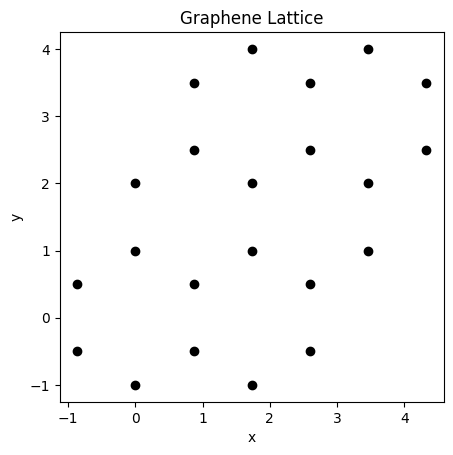

In [8]:
nx = 2
ny = 3
positions = graphene_generator.generate_positions(nx, ny)

x, y = zip(*positions)
plt.scatter(x, y, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphene Lattice')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# Test

In [5]:
potentials = []
interactions = {}

bond_length = 1.01
interaction_energy = [0, 0, 0, -0.1]
interactions = graphene_generator.find_bonded_interactions(positions, bond_length, interaction_energy)

In [6]:
vertices_count = len(positions)
species_count = 2
dimension = 2
graphene = CrystalStructure(vertices_count, species_count, dimension)

for position in positions:
    graphene.add_position(*position)

for interaction in interactions:
    graphene.add_interaction(interaction[0], interaction[1], interactions[interaction])


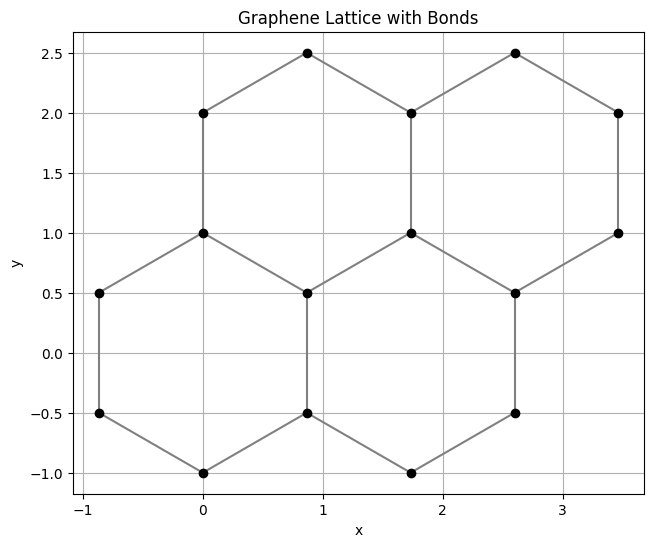

In [7]:
# Plotting the lattice with bonds
plt.figure(figsize=(8, 6))
for (i, j), _ in interactions.items():
    pos1 = positions[i]
    pos2 = positions[j]
    plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'gray')  # Draw a line for the bond

# Unpack positions for plotting atoms
x, y = zip(*positions)
plt.scatter(x, y, color='black', zorder=3)  # zorder=3 to draw atoms on top of the bonds

plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphene Lattice with Bonds')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

In [ ]:
crystal_file = '../native_crystal_database/graphene_supercell.dat'
graphene.to_file(crystal_file)